In [30]:
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(readr)
library(repr)

In [31]:
#data wrangling part
url1<-"https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"
url2<-"https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"

session_data <- read_csv(url1)
players_data<-read_csv(url2)

session_data_wrangle<-session_data|>             
                      mutate(start_time=dmy_hm(start_time),
                      end_time=dmy_hm(end_time)
                    )|>
              filter(!is.na(start_time)&!is.na(end_time))|>
              mutate(Duration=as.numeric(end_time-start_time,unit="mins")
                    )|>
              group_by(hashedEmail)|>
              mutate(frequency = n(),
                     total_duration=sum(Duration,na.rm=TRUE)
                    ) |>
              ungroup()

players_data_wrangle<-players_data|>
                      select(-individualId,-organizationName)|>
                      mutate(experience = as.factor(experience),
                             subscribe = as.factor(subscribe),
                             gender = as.factor(gender))|>
                      filter(!is.na(experience) & !is.na(played_hours) & !is.na(age))



combined_data <- session_data_wrangle|>
                     left_join(players_data_wrangle, by = "hashedEmail")

  
combined_data_plot<-combined_data|>
               distinct(hashedEmail,start_time,.keep_all = TRUE)|>
               select(played_hours, name, gender, age,Duration,frequency, total_duration, experience, subscribe)|>
               distinct(name,.keep_all = TRUE)|>
               select(played_hours,gender,age,experience,frequency,total_duration)|>
               filter(age>=15&age<=30)



# head(session_data,10)
# head(players_data,10)
# head(combined_data_1,10)
# view the data if you need,I use head() so that it won't seem to be too long or take up too much space.

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Warning message in scale_y_log10(labels = comma):
“log-10 transformation introduced infinite values.”


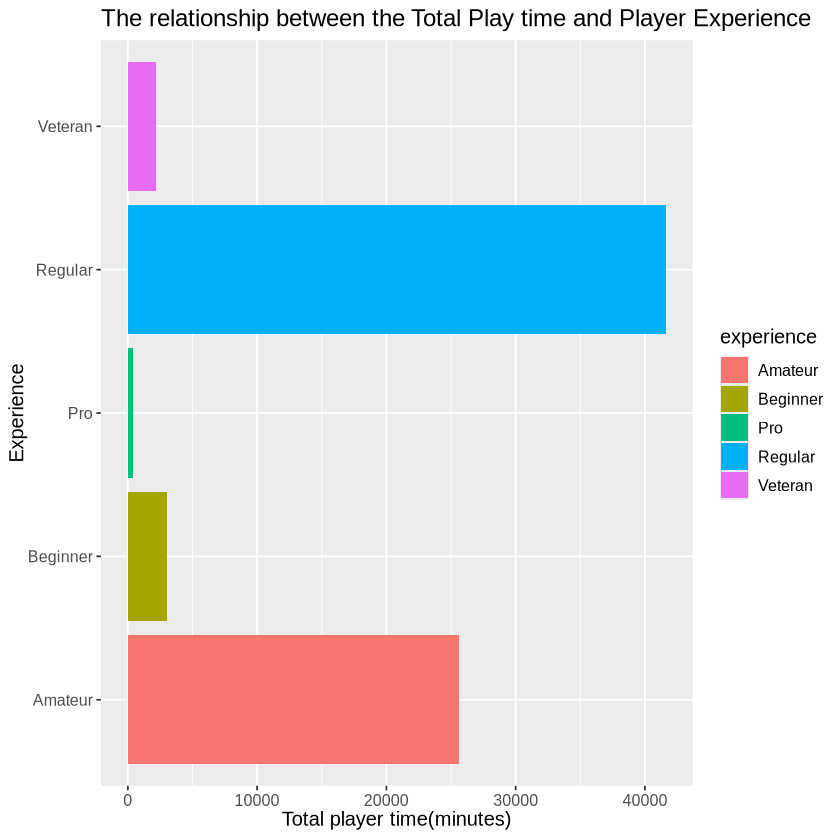

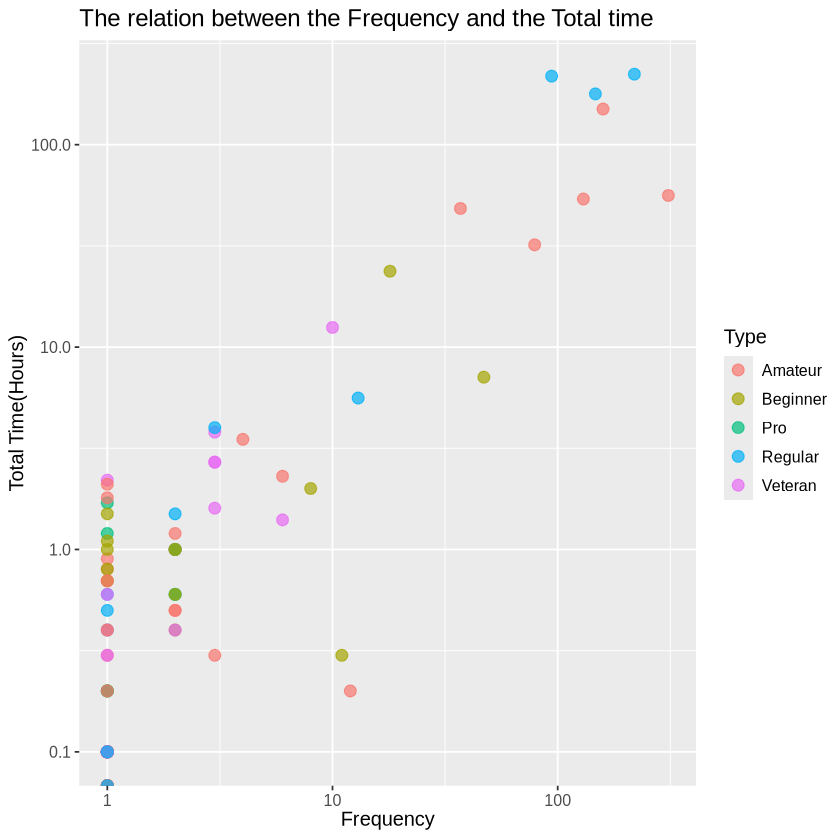

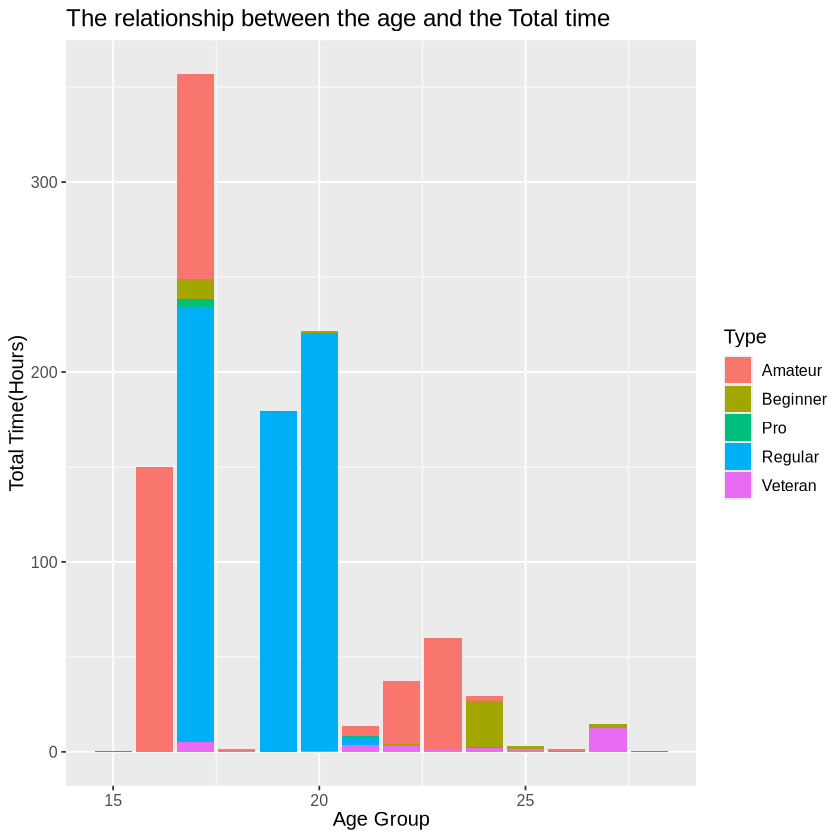

In [32]:
#visualization part
analysis_plot_1<-combined_data_plot|>
               ggplot(aes(x=total_duration,y=experience,fill = experience))+
               geom_bar(stat="identity")+
               labs(
                   title="The relationship between the Total Play time and Player Experience",
                   y="Experience",
                   x="Total player time(minutes)"
               )+
               theme(text=element_text(size=12))
analysis_plot_1
#time vs experience
analysis_plot_2<-combined_data_plot|>
               ggplot(aes(x=frequency,y=played_hours,colour = experience))+
               geom_point(size = 3, alpha = 0.7)+
               labs(
                   title="The relation between the Frequency and the Total time",
                   x="Frequency",
                   y="Total Time(Hours)",
                   colour="Type"
               )+
               scale_x_log10(labels=comma)+
               scale_y_log10(labels=comma)+
               theme(text=element_text(size=12))
analysis_plot_2
#time vs frequency
analysis_plot_3<-combined_data_plot|>
               ggplot(aes(x=age,y=played_hours,fill = experience))+
               geom_bar(stat="identity")+
               labs(
                   title="The relationship between the age and the Total time",
                   x="Age Group",
                   y="Total Time(Hours)",
                   fill="Type"
               )+
               theme(text=element_text(size=12))
analysis_plot_3
#time vs age

In [33]:
# spliting data
set.seed(1004)
# maybe you can change the seed to split in a better way and get a better plot

combined_data_model <- combined_data_plot|>
                    select(played_hours,frequency,age,experience)
#                filter(played_hours > ...)
# if you need to filter whose playe_hours is 0 ^-^

mc_data <- combined_data_model |>
  mutate(played_degree = cut(
    played_hours,
    breaks = c(0, 1, 4, Inf),
    labels = c("Try","Play","Enjoy"),
    include.lowest = TRUE))
mc_split <- initial_split(mc_data,prop=0.80,strata=played_degree)
mc_training <- training(mc_split)
mc_testing <- testing(mc_split)
# mc_training
# mc_testing

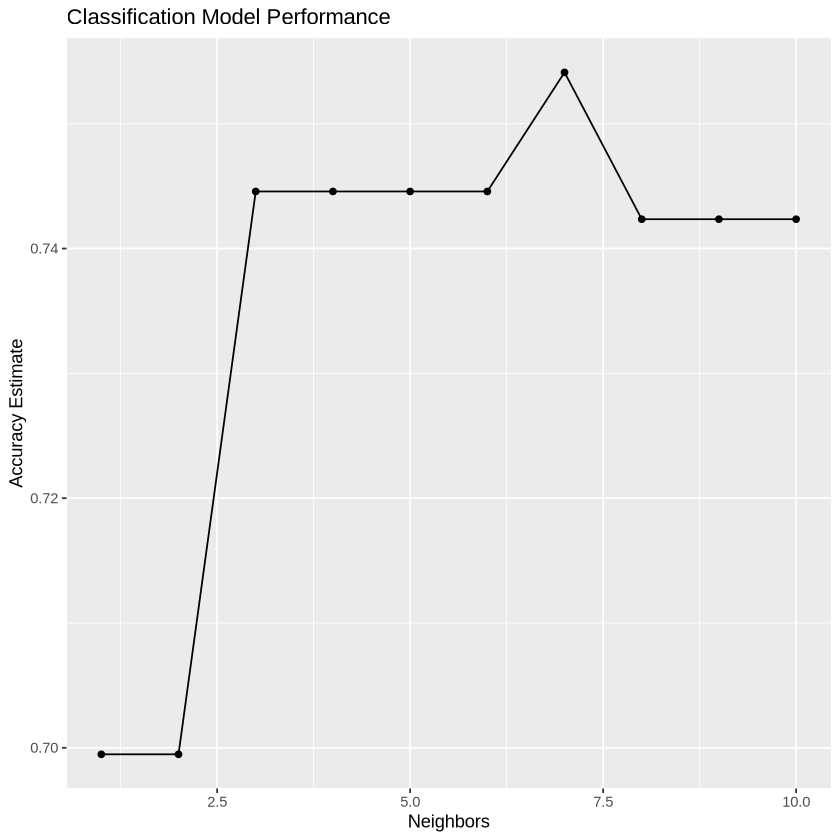

In [34]:
#classification part
set.seed(1004)
mc_recipe <- recipe(played_degree ~ ., data = mc_training) |>
  step_rm(played_hours) |>
  step_integer(all_predictors()) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

mc_vfold <- vfold_cv(mc_training, v = 5, strata = played_degree)#cross-validation

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_results <- workflow() |>
  add_recipe(mc_recipe) |>
  add_model(knn_tune) |>
  tune_grid(resamples = mc_vfold, grid = k_vals) |>
  collect_metrics()|> 
  filter(.metric == "accuracy")

cross_val_plot <- ggplot(knn_results, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "Classification Model Performance")
cross_val_plot #the plot to choose best k
#we may choose k= 7

mc_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |>
  set_engine("kknn") |>
  set_mode("classification")

mc_classification_results <- workflow() |>
  add_recipe(mc_recipe) |>
  add_model(mc_spec) |>
  fit(data = mc_training) |>
  predict(new_data = mc_testing)

# mc_classification_results # the result of classification(a lot of Try QnQ)

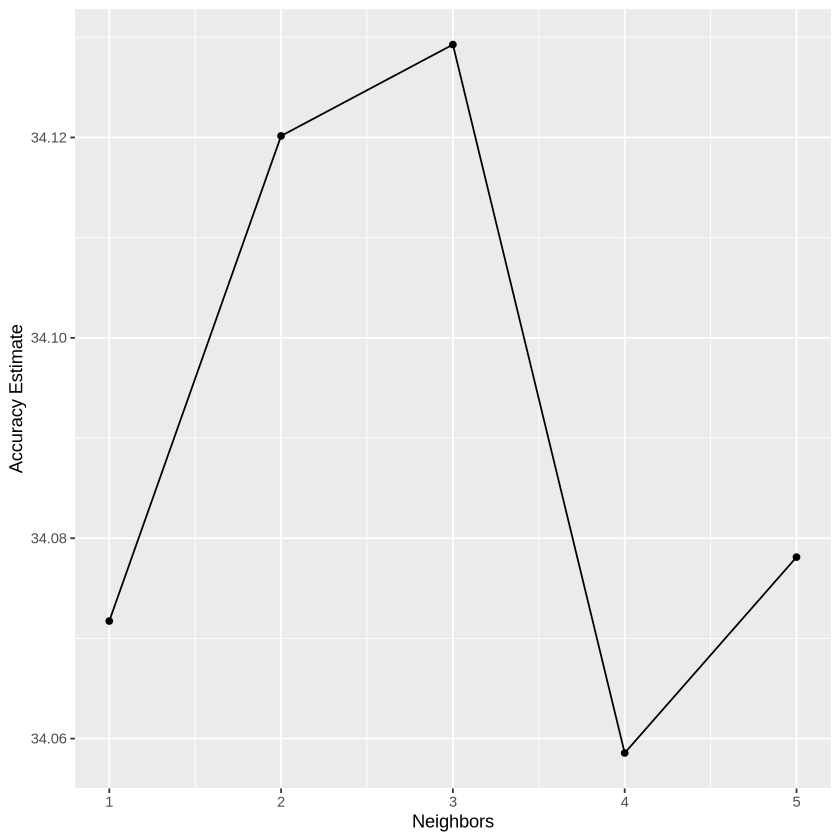

In [35]:
#regression part
set.seed(104)
mc_recipe_regression <- recipe(played_hours~ ., data = mc_training)|>
    step_integer(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

mc_vfold_regression <- vfold_cv(mc_training, v = 5, strata = played_hours)

knn_tune_regression <- nearest_neighbor(weight_func = "rectangular" ,neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("regression")

k_vals_regression <- tibble(neighbors = seq(from = 1, to = 5, by = 1))

knn_results_regression <- workflow() |>
      add_recipe(mc_recipe_regression) |>
      add_model(knn_tune_regression) |>
      tune_grid(resamples =  mc_vfold_regression, grid = k_vals_regression) |>
      collect_metrics()|> 
      filter(.metric == "rmse")

cross_val_plot <- ggplot(knn_results_regression, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate")
cross_val_plot #the plot to choose best k
#we may choose k= 3

mc_spec_regression <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
  set_engine("kknn") |>
  set_mode("regression")

mc_regression_results <- workflow() |>
  add_recipe(mc_recipe_regression) |>
  add_model(mc_spec_regression) |>
  fit(data = mc_training) |>
  predict(new_data = mc_testing)

# knn_rmspe <- workflow() |>
#          add_recipe(mc_recipe) |>
#          add_model(mc_spec) |>
#          fit(data = mc_training) |>
#           predict(new_data= mc_testing) |>
#           bind_cols(mc_testing) |>
#           metrics(truth =played_hours, estimate = .pred)
# knn_rmspe 
#I'm not sure whether we need this part or not

# mc_regression_results# the result of regression